In [1]:
import pandas as pd 
import scanpy as sc
import anndata
import numpy as np
import torch
import scvelo as scv
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.metrics.pairwise import cosine_similarity
from spvelo import *
import pytorch_lightning
import squidpy as sq
from scipy import sparse

In [2]:
ct_key = 'cluster_annotations'
batch_key = 'batch'
spatial_key = 'spatial'
velocity_key = 'velocity'

In [3]:
adata = anndata.read_h5ad('/gpfs/gibbs/pi/zhao/wl545/spatial_velo_sorted/OSCC/concat_pp_wonc.h5ad')

In [4]:
all_genes = adata.var_names.tolist()

In [5]:
from velovi import preprocess_data
adata = preprocess_data(adata)
var_mtx = adata.var.copy()
sorted_var = var_mtx.sort_values(by='velocity_r2')
low_r2 = sorted_var[sorted_var.velocity_r2<0.2].index.tolist()
print(len(low_r2))

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
160


In [9]:
import gseapy
from gseapy.stats import calc_pvalues, multiple_testing_correction
from collections import OrderedDict
def parse_background(gmt):
    """
    set background genes
    """
    bg = set()
    for term, genes in gmt.items():
        bg = bg.union(set(genes))
    return bg
def get_gsea_scores(gene_list, gmt, pathway_list=None, cutoff=0.05):
    if pathway_list == None:
        pathway_list = list(gmt.keys())
    
    gmt = {k: gmt[k] for k in pathway_list}
    bg = parse_background(gmt)
    hgtest = list(calc_pvalues(query=gene_list, gene_sets=gmt, background=bg))
    if len(hgtest) > 0:
        terms, pvals, oddr, olsz, gsetsz, genes = hgtest
        fdrs, rej = multiple_testing_correction(
            ps=pvals, alpha=cutoff, method="benjamini-hochberg"
        )
        # save to a dataframe
        odict = OrderedDict()
        odict["Term"] = terms
        odict["Overlap"] = list(map(lambda h, g: "%s/%s" % (h, g), olsz, gsetsz))
        odict["P-value"] = pvals
        odict["Adjusted P-value"] = fdrs
        odict["Odds Ratio"] = oddr
        odict["Combined Score"] = -1 * np.log(pvals) * oddr
        # odict['Reject (FDR< %s)'%self.cutoff ] = rej
        odict["Genes"] = [";".join(map(str, g)) for g in genes]
        res = pd.DataFrame(odict)
    return res

In [10]:
from gseapy import Msigdb
msig = Msigdb()
gmt = msig.get_gmt(category='c5.all', dbver="2023.2.Hs")

In [11]:
df_uninfo = get_gsea_scores(low_r2, gmt)
df_uninfo['gene_set'] = "uninformative genes"
import random
rand_genes = random.sample(list(set(all_genes) - set(low_r2)), len(low_r2))
df_control = get_gsea_scores(rand_genes, gmt)
df_control['gene_set'] = "control group"
df = pd.concat([df_uninfo, df_control])

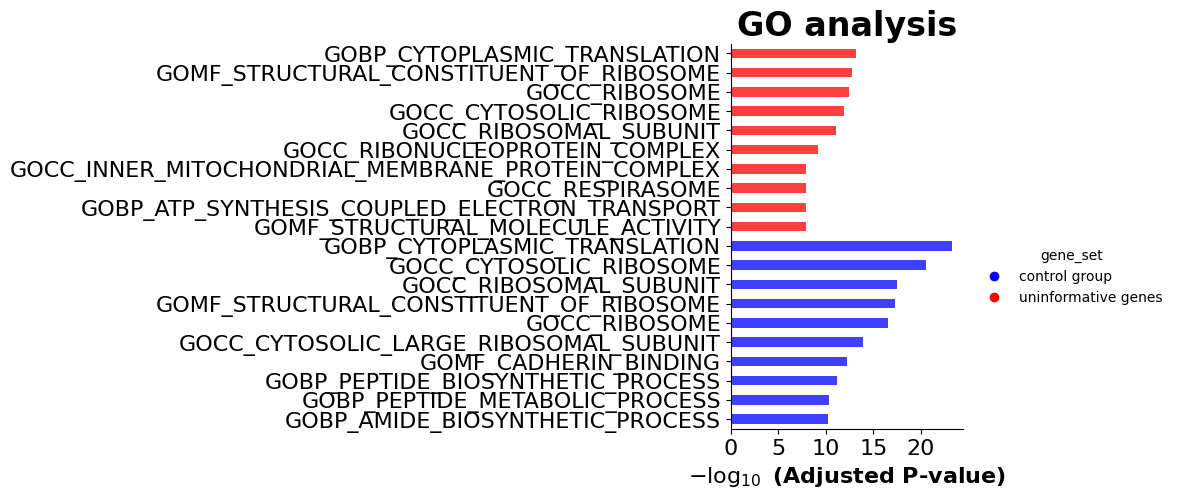

In [12]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'
ax = gseapy.barplot(df, figsize=(3,5),
                group ='gene_set',
                title ="GO analysis",
                color = ['b','r'])

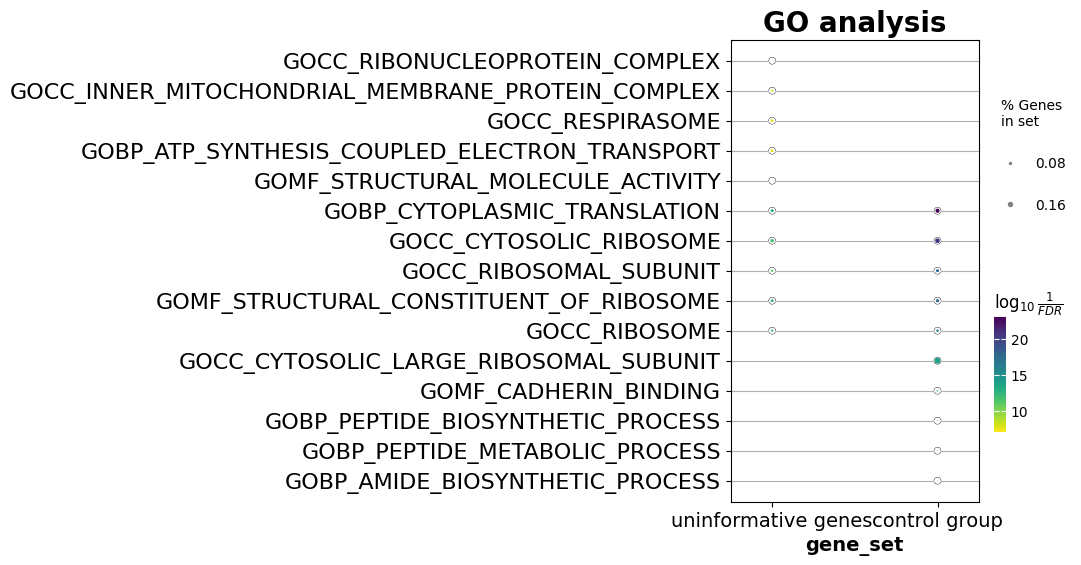

In [13]:
ax = gseapy.dotplot(df,
                x='gene_set',
                x_order = ["uninformative genes","control group"],
                title="GO analysis",
                size=3,
                show_ring=True)
plt.show()